In [3]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import collections 
from utils.analysis_utils import analyze_pool
def makehash():
    return collections.defaultdict(makehash)
import fnmatch 
import torch 
from tqdm import tqdm 
from utils import save_dir, analyze_dir, result_dir,train_pool
import scipy.spatial.distance as dist
from tqdm import tqdm
import re
from sklearn.manifold import TSNE
import itertools 


def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()
av_window=10

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier='mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
#epochs-10_batch-32_lr-0.001_momentum-0.5_init-gaussian_std-0.0001
#                           epochs-10_batch-32_lr-0.002_momentum-0.6_init-gaussian_std-1e-05 \
#                           epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06 

In [5]:
# load training data 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

Load extracted gradient data (from extraction script!)

In [6]:
grad_pkl_files = []
for file in os.listdir(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*gradient_data.pkl'):
        grad_pkl_files.append(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier,file))
s = [re.findall('/\d+', x) for x in grad_pkl_files]
s = [item for sublist in s for item in sublist]
dummy_id = [(x.split('/')) for x in s]
file_id = [int(x.split('/')[1]) for x in s]
sorted_files = [grad_pkl_files[x] for x in np.argsort(file_id)]
grad_pkl_files=sorted_files

In [7]:
params = train_pool[model_identifier]()
params.load_dataset()
transfo_mat=params.dataset.transformation_mats

<HDF5 dataset "data": shape (128252,), type "|u1"> is not a matlab type
<HDF5 dataset "ir": shape (128252,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (64128,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
data type not supported: graph, uint32


Make a transformation matrix that does not average across num examples

In [8]:
tiled_transfo_mat=[np.tile(x,(1,50)).reshape(-1,x.shape[1]) for x in transfo_mat]
w=[np.apply_along_axis(np.where,1,x).reshape([-1,1])+1 for x in tiled_transfo_mat]

In [9]:
w_fixed=[[(np.arange(w[0].shape[0])+1).reshape(-1,1)],w]
within_class_ids = [item for sublist in w_fixed for item in sublist]
between_class_ids=[within_class_ids[1:],[within_class_ids[0]*0+1]]
between_class_ids = [item for sublist in between_class_ids for item in sublist]

In [8]:
withins=[]
betweens=[]
for k in range(len(between_class_ids)):
    temp=np.matmul(within_class_ids[k],within_class_ids[k].transpose())
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),temp.shape[0],axis=0)
    within_class=temp==temp1;
    withins.append(within_class)
    temp=np.matmul(between_class_ids[k],between_class_ids[k].transpose())
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),temp.shape[0],axis=0)
    between_class=temp==temp1;
    betweens.append(between_class)

hier_within_class=[]
hier_between_class=[]
for idx, _ in enumerate(range(len(betweens)-1)):
    A=withins[idx]==(~withins[idx+1])
    hier_within_class.append(A)
    
    B=betweens[idx]==(~betweens[idx+1])
    hier_between_class.append(B)

Extract gradient data for a particular layer across all time points

In [22]:
all_grad_within=[]
all_grad_between=[]
all_grad_data=[]
for idx,file in tqdm(enumerate(grad_pkl_files)):
    g=pickle.load(open(file,'rb'))
    e=np.asarray(g['results'][0]['layer_3_Linear']).squeeze()
    all_grad_data.append(e)
  

1060it [00:57, 18.54it/s]


In [46]:
e.shape

(64, 50, 64)

In [235]:
all_grad_data4=[]
for idx,file in tqdm(enumerate(grad_pkl_files)):
    g=pickle.load(open(file,'rb'))
    e=np.asarray(g['results'][1]['layer_1_Linear']).squeeze()
    all_grad_data4.append(e)

1060it [01:42, 10.37it/s]


Find indices for all pairwise difference comparisons among leafy branches!

In [11]:
analyze_params = analyze_pool[analyze_identifier]()
analyze_params.exm_per_class

50

In [155]:
a = list(range(50))
combs=list(itertools.combinations_with_replacement(a, r=2))
len(combs)

1275

In [157]:
combs_1=list(itertools.combinations(a, r=2))
combs_1=[(x[1],x[0]) for x in combs_1]


In [ ]:
# make sure we also get the reversed indices! because combinations does not do asymmetric pairs
all_combs=[combs,combs_1]
all_combs = [item for sublist in all_combs for item in sublist]
all_combs_mat=np.asarray(all_combs)

In [42]:
len(g['results'][2]['layer_1_Linear'])

16

In [18]:
e_f=np.reshape(all_grad_data[1],[-1,all_grad_data[1].shape[2]])

In [176]:
all_combs=[(x[0],x[1]+50) for x in all_combs]


In [12]:
layer_names = params.get_layer_names()

In [48]:
transfo=tiled_transfo_mat[0]
int(np.unique(transfo.sum(axis=0)))

50

In [54]:
P12=e_f[np.where(tiled_transfo_mat[1][:,0]==1),:].squeeze()

In [182]:
p12_diff=[np.diff(P12[x,:],axis=0) for x in all_combs]

In [ ]:
np.mean(np.stack(p12_diff).squeeze(),axis=0)

In [206]:
branch_diffs=[]
for branch in tiled_transfo_mat[1].transpose(): # for each single "over" branch, iterate through the categories
    P12=e_f[np.where(branch==1),:].squeeze() # extract each category
    p12_diff=[np.diff(P12[x,:],axis=0) for x in all_combs] # find all pairwise differences between all samples in cat 1 and cat 2 (the leaf branches)
    branch_diffs.append(np.mean(np.stack(p12_diff).squeeze(),axis=0)) # take mean over all the pairwise diffs

In [210]:
branch_diffs[1].shape

(624,)

In [ ]:
[np.linalg.norm(x) for x in branch_diffs]

In [49]:
transfo.transpose()

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

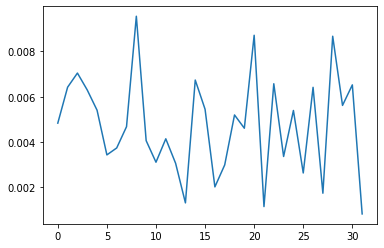

In [214]:
plt.plot([np.linalg.norm(x) for x in branch_diffs])

In [16]:
e_f_list=[np.reshape(x,[-1,x.shape[2]]) for x in all_grad_data]

Compute all pairwise differences across 32 level across all time points!! :)

In [219]:
all_branch_diffs=[]
for _,time_point in tqdm(enumerate(e_f_list)):
    branch_diffs=[]
    for branch in tiled_transfo_mat[1].transpose(): # for each single "over" branch, iterate through the categories
        P12=time_point[np.where(branch==1),:].squeeze() # extract each category
        p12_diff=[np.diff(P12[x,:],axis=0) for x in all_combs] # find all pairwise differences between all samples in cat 1 and cat 2 (the leaf branches)
        branch_diffs.append(np.mean(np.stack(p12_diff).squeeze(),axis=0)) # take mean over all the pairwise diffs
    all_branch_diffs.append(branch_diffs)

657it [25:44,  2.35s/it]


KeyboardInterrupt: 

In [223]:
branch_norm=[[np.linalg.norm(x) for x in branch_diffs] for branch_diffs in all_branch_dall_branch_diffs]

In [228]:
branc_norm_mat=np.stack(branch_norm)

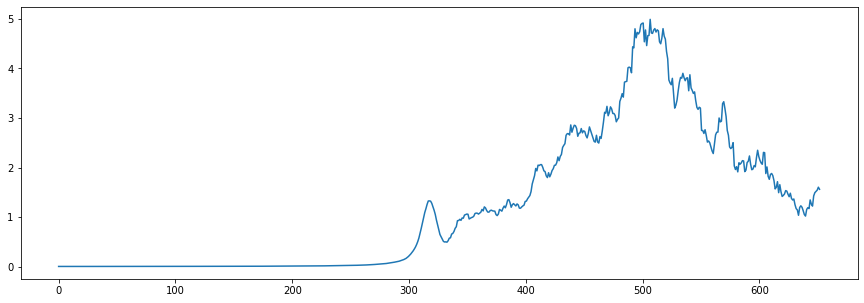

In [232]:
plt.figure(figsize=(15,5))
plt.plot(moving_average(np.arange(branc_norm_mat.shape[0]),10),moving_average(np.mean(branc_norm_mat,axis=1),10))#,#yerr=np.std(branc_norm_mat,axis=1))

In [52]:
layer_branch_data=dict()

In [58]:
layer_branch_data[f"hier_{1}"]=np.ones(1)

In [59]:
layer_branch_data

{1: array([1.]), 'hier1': array([1.]), 'hier_1': array([1.])}

In [60]:
layer_gradient_dict=dict()


In [64]:
layer=layer_names[1]
layer_gradient_dict[layer]=layer_branch_data

In [65]:
layer_gradient_dict

{'layer_2_Linear': {1: array([1.]),
  'hier1': array([1.]),
  'hier_1': array([1.])}}

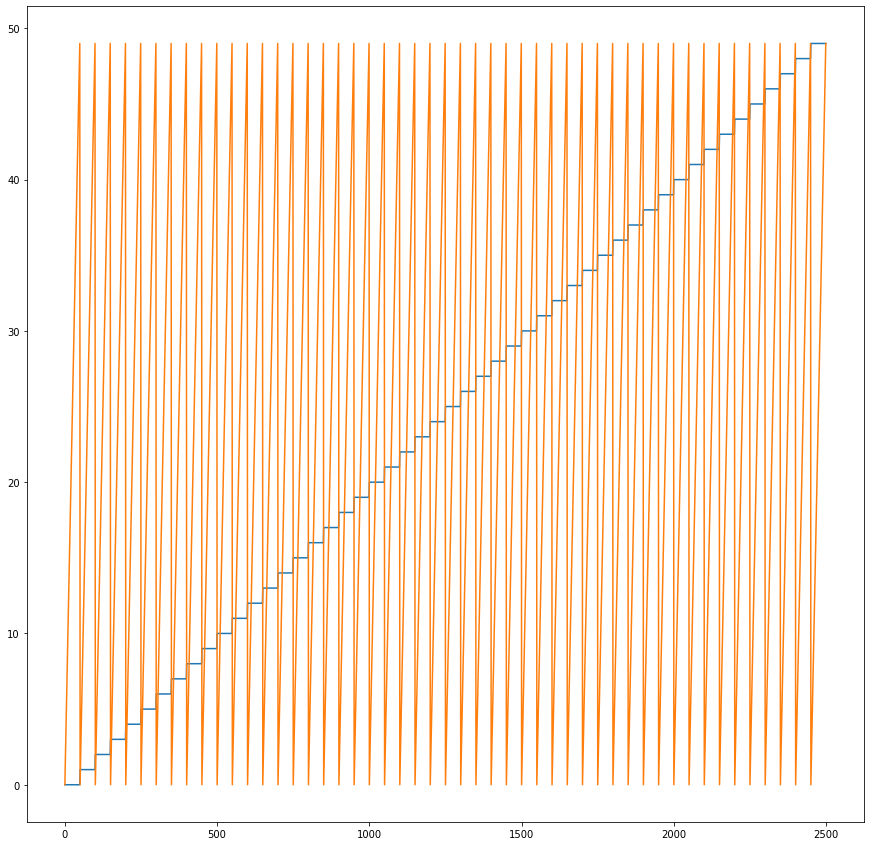

In [142]:
plt.figure(figsize=(15,15))
plt.plot(first_idx)
plt.plot(second_idx-50)

# 4 classes 

In [244]:
a = list(range(800))
combs=list(itertools.combinations_with_replacement(a, r=2))
len(combs)
combs_1=list(itertools.combinations(a, r=2))
combs_1=[(x[1],x[0]) for x in combs_1]



In [245]:
# make sure we also get the reversed indices! because combinations does not do asymmetric pairs
all_combs=[combs,combs_1]
all_combs = [item for sublist in all_combs for item in sublist]
all_combs_mat=np.asarray(all_combs)

In [260]:
branch_diffs_1=[]
for branch in tiled_transfo_mat[4].transpose(): # for each single "over" branch, iterate through the categories
    P12=e_f[np.where(branch==1),:].squeeze() # extract each category
    random_combs=[all_combs[x] for x in np.random.choice(np.arange(len(all_combs)),size=2500)]
    p12_diff=[np.diff(P12[x,:],axis=0) for x in random_combs] # find all pairwise differences between all samples in cat 1 and cat 2 (the leaf branches)
    branch_diffs_1.append(np.mean(np.stack(p12_diff).squeeze(),axis=0)) # take mean over all the pairwise diffs

(624,)

In [266]:
all_branch_diffs_4=[]
for _,time_point in tqdm(enumerate(e_f_list)):
    branch_diffs_4=[]
    for branch in tiled_transfo_mat[4].transpose(): # for each single "over" branch, iterate through the categories
        P12=time_point[np.where(branch==1),:].squeeze() # extract each category
        random_combs=[all_combs[x] for x in np.random.choice(np.arange(len(all_combs)),size=2500)]
        p12_diff=[np.diff(P12[x,:],axis=0) for x in random_combs] # find all pairwise differences between all samples in cat 1 and cat 2 (the leaf branches)
        branch_diffs_4.append(np.mean(np.stack(p12_diff).squeeze(),axis=0)) # take mean over all the pairwise diffs
    all_branch_diffs_4.append(branch_diffs_4)

1060it [06:18,  2.80it/s]


In [51]:
50**2

2500

In [267]:
branch_norm_4=[[np.linalg.norm(x) for x in branch_diffs] for branch_diffs in all_branch_diffs_4]
branc_norm_4_mat=np.stack(branch_norm_4)[:657,:]

(657, 4)

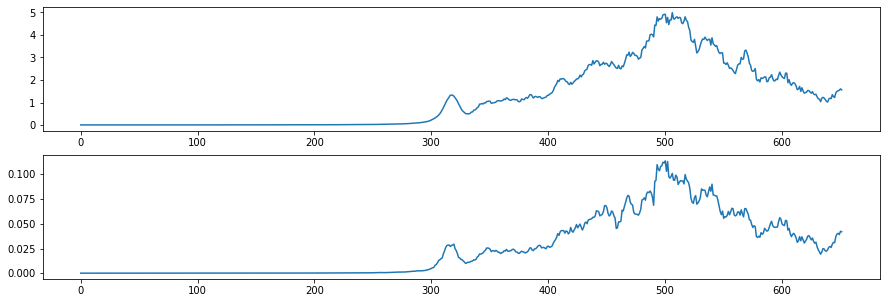

In [271]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(moving_average(np.arange(branc_norm_mat.shape[0]),10),moving_average(np.mean(branc_norm_mat,axis=1),10))#,#yerr=np.std(branc_norm_mat,axis=1))
plt.subplot(2,1,2)
plt.plot(moving_average(np.arange(branc_norm_4_mat.shape[0]),10),moving_average(np.mean(branc_norm_4_mat,axis=1),10))#,#yerr=np.std(branc_norm_mat,axis=1))

# do analysis in torch

In [40]:
torch.cuda.get_device_name(0)
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True


In [48]:
e_f_list=[torch.tensor(np.reshape(x,[-1,x.shape[2]]),device=device,dtype = float,requires_grad=False) for x in all_grad_data]


3200

In [49]:
e_f_tensor=torch.stack(e_f_list)#.device=device,dtype = float,requires_grad=False)

In [51]:
e_f_tensor.shape

torch.Size([1060, 3200, 64])

In [11]:
a = list(range(800))
combs=list(itertools.combinations_with_replacement(a, r=2))
len(combs)
combs_1=list(itertools.combinations(a, r=2))
combs_1=[(x[1],x[0]) for x in combs_1]

# make sure we also get the reversed indices! because combinations does not do asymmetric pairs
all_combs=[combs,combs_1]
all_combs = [item for sublist in all_combs for item in sublist]
all_combs_mat=np.asarray(all_combs)

In [ ]:
branch_diffs_1=[]
for branch in tiled_transfo_mat[4].transpose(): # for each single "over" branch, iterate through the categories
    P12=torch.tensor(e_f[np.where(branch==1),:].squeeze() # extract each category
    p12_diff=[np.diff(P12[x,:],axis=0) for x in random_combs] # find all pairwise differences between all samples in cat 1 and cat 2 (the leaf branches)
    branch_diffs_1.append(np.mean(np.stack(p12_diff).squeeze(),axis=0)) # take mean over all the pairwise diffs

In [25]:
branch=tiled_transfo_mat[4][:,0]
P12=torch.tensor(e_f[np.where(branch==1),:].squeeze()) # extract each category

In [33]:
P_pairs=P12[all_combs,:]

In [37]:
torch.mean(P_pairs[:,1,:]-P_pairs[:,0,:],axis=0)

torch.Size([64])

In [38]:
torch.tensor(1,device=device,dtype = float,requires_grad=False)

device(type='cpu')

In [98]:
e_f_tensor.shape
e_f[np.argwhere(branch==1),:]

RuntimeError: CUDA error: device-side assert triggered

In [84]:
all_branch_diffs_4=[]
for k in tqdm(range(e_f_tensor.shape[0])):
    e_f=e_f_tensor[k,:,:]
    branch_diffs_4=[]
    for branch in tiled_transfo_mat[1].transpose(): # for each single "over" branch, iterate through the categories
        P12=e_f[torch.where(branch==1),:].squeeze()
        P_pairs=P12[all_combs,:]
        branch_diffs_4.append(torch.mean(P_pairs[:,1,:]-P_pairs[:,0,:],axis=0))
    all_branch_diffs_4.append(branch_diffs_4)

  0%|          | 0/1060 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered

In [82]:
branch_norm_4=[[np.linalg.norm(x.cpu().numpy()) for x in branch_diffs] for branch_diffs in all_branch_diffs_4]
branc_norm_4_mat=np.stack(branch_norm_4)

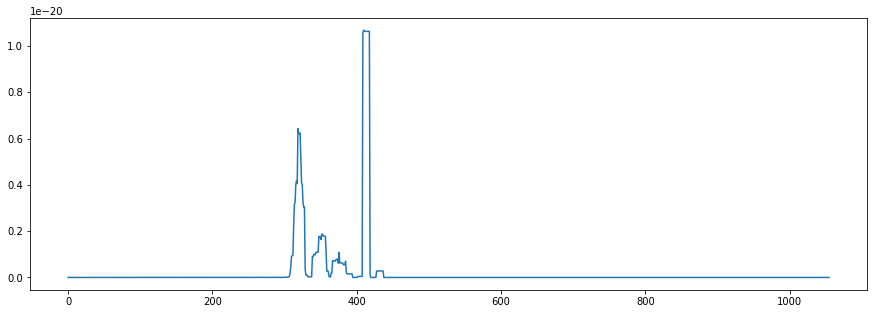

In [83]:
plt.figure(figsize=(15,5))
plt.plot(moving_average(np.arange(branc_norm_4_mat.shape[0]),10),moving_average(np.mean(branc_norm_4_mat,axis=1),10))#,#yerr=np.std(branc_norm_mat,axis=1))

In [69]:
p12_tensor=e_f_tensor[:,np.where(branch==1),:].squeeze()

In [74]:
p12_pair=p12_tensor[:,all_combs[1:100],:]

In [75]:
all_branch_diffs_4=[]
for _,time_point in tqdm(enumerate(e_f_list)):
    branch_diffs_4=[]
    for branch in tiled_transfo_mat[4].transpose(): # for each single "over" branch, iterate through the categories
        P12=time_point[np.where(branch==1),:].squeeze() # extract each category
        random_combs=[all_combs[x] for x in np.random.choice(np.arange(len(all_combs)),size=2500)]
        p12_diff=[np.diff(P12[x,:],axis=0) for x in random_combs] # find all pairwise differences between all samples in cat 1 and cat 2 (the leaf branches)
        branch_diffs_4.append(np.mean(np.stack(p12_diff).squeeze(),axis=0)) # take mean over all the pairwise diffs
    all_branch_diffs_4.append(branch_diffs_4)

AttributeError: 'list' object has no attribute 'shape'